## Basic Setup

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import networkx as nx


from platform import python_version
print("Python Version", python_version())
print('PyTorch Version', torch.__version__)

Python Version 3.7.12
PyTorch Version 1.10.0+cu111


In [ ]:
# Device
DEVICE = 'cpu'
if torch.cuda.is_available():
    DEVICE = "cuda"
print("device =", DEVICE)
# Reproducibility
SEED = 3407
import random
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
# Parallel processing
NUM_CORES = 20
torch.set_num_threads(NUM_CORES)

device = cpu


In [ ]:
if DEVICE=="cpu":
    !pip install -q torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cpu.html
else:
    !pip install -q torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
import torch_geometric as pyg
print('PyTorch Geometric Version', pyg.__version__)

PyTorch Geometric Version 2.0.2


## Prepare graph

In [ ]:
def to_node_idx(x,y):
    return (8*x) + y

def to_coord(node_idx):
    return node_idx//8, node_idx%8

edge_index = [[],[]]
for i in range(8):
    for j in range(8):
        if i<7:
            edge_index[0].append(to_node_idx(i,j));    edge_index[1].append(to_node_idx(i+1,j))
            edge_index[0].append(to_node_idx(i+1,j));    edge_index[1].append(to_node_idx(i,j))
        if i>0:
            edge_index[0].append(to_node_idx(i,j));    edge_index[1].append(to_node_idx(i-1,j))
            edge_index[0].append(to_node_idx(i-1,j));    edge_index[1].append(to_node_idx(i,j))
        if j<7:
            edge_index[0].append(to_node_idx(i,j));    edge_index[1].append(to_node_idx(i,j+1))
            edge_index[0].append(to_node_idx(i,j+1));    edge_index[1].append(to_node_idx(i,j))
        if j>0:
            edge_index[0].append(to_node_idx(i,j));    edge_index[1].append(to_node_idx(i,j-1))
            edge_index[0].append(to_node_idx(i,j-1));    edge_index[1].append(to_node_idx(i,j))

edge_index = torch.tensor(edge_index, dtype=torch.long).to(DEVICE)
COINS = set([10, 30, 50])

In [ ]:
data = pyg.data.Data(edge_index = edge_index).to(DEVICE)
NUM_NODES = data.num_nodes
NUM_EDGES = data.num_edges
print("No. of nodes =", NUM_NODES)
print("No. of edges =", NUM_EDGES)
print("edge_index.shape =", data.edge_index.shape)

No. of nodes = 64
No. of edges = 448
edge_index.shape = torch.Size([2, 448])


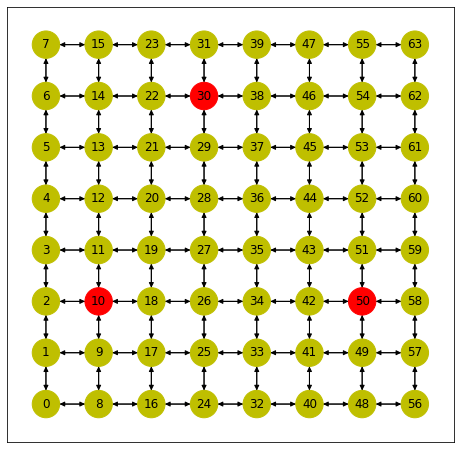

In [ ]:
graph = pyg.utils.to_networkx(data)
pos = {}
for idx in range(64):
    x,y = to_coord(idx)
    pos[idx] = np.array([x,y])

fig, ax = plt.subplots(figsize=(8, 8))
color = ['y' for i in range(64)]
for coin in COINS:
    color[coin] = 'r'
nx.drawing.nx_pylab.draw_networkx(graph, node_color=color, pos=pos, node_size=750, ax=ax)

In [ ]:
def plot_policy(policy):
    u = [[0.75 for i in range(8)] for j in range(8)]
    v = [[0.75 for i in range(8)] for j in range(8)]
    for state in range(64):
        x,y = to_coord(state)
        action = np.argmax(policy[state])
        if action==0:
            u[y][x] = 0
            v[y][x] = 0.75
        elif action==1:
            u[y][x] = 0.75
            v[y][x] = 0
        elif action==2:
            u[y][x] = 0
            v[y][x] = -0.75
        else:
            u[y][x] = -0.75
            v[y][x] = 0

    graph = pyg.utils.to_networkx(data)
    pos = {}
    for idx in range(64):
        x,y = to_coord(idx)
        pos[idx] = np.array([x,y])

    fig, ax = plt.subplots(figsize=(8, 8))
    color = ['y' for i in range(64)]
    for coin in COINS:
        color[coin] = 'r'
    nx.drawing.nx_pylab.draw_networkx(graph, node_color=color, pos=pos, node_size=750, ax=ax, edgelist=[])
    
    X = np.arange(0,8,1)
    Y = np.arange(0,8,1)

    ax.quiver(X, Y, u, v, scale_units='xy', scale=1)
    
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.set_aspect('equal')
    plt.grid()
    plt.show()

## 3. Define random walker and Initialize policy

In [ ]:
POLICY = {}
for i in range(8):
    for j in range(8):
        u = to_node_idx(i,j)
        POLICY[u] = np.array([0.0, 0.0, 0.0, 0.0])
        if j<7: # up
            POLICY[u][0] = 1.0
        if i<7: # right
            POLICY[u][1] = 1.0
        if j>0: # down
            POLICY[u][2] = 1.0
        if i>0: # left
            POLICY[u][3] = 1.0
        POLICY[u] /= sum(POLICY[u])

Q = {}
for i in range(8):
    for j in range(8):
        u = to_node_idx(i,j)
        Q[u] = {}
        if j<7: # up
            Q[u][0] = torch.rand(1)
        if i<7: # right
            Q[u][1] = torch.rand(1)
        if j>0: # down
            Q[u][2] = torch.rand(1)
        if i>0: # left
            Q[u][3] = torch.rand(1)

RET = {}
for i in range(8):
    for j in range(8):
        u = to_node_idx(i,j)
        RET[u] = [[], [], [], []]

In [ ]:
def sample_episode(walk_len, start_node=None):
    if start_node==None:
        start_node = np.random.randint(0,NUM_NODES)
    states = []
    actions = []
    rewards = []
    curr_state = start_node
    while len(states) < walk_len:
        states.append(curr_state)
        if curr_state in COINS:
            rewards.append(1.0)
        else:
            rewards.append(0.0)
        
        actions.append(np.random.choice(a=[0,1,2,3], size=None, replace=True, p=POLICY[curr_state]))
        if actions[-1]==0:      # up
            curr_state = to_node_idx(to_coord(curr_state)[0], to_coord(curr_state)[1]+1)
        elif actions[-1]==1:    # right
            curr_state = to_node_idx(to_coord(curr_state)[0]+1, to_coord(curr_state)[1])
        elif actions[-1]==2:    # down
            curr_state = to_node_idx(to_coord(curr_state)[0], to_coord(curr_state)[1]-1)
        else:                   # left
            curr_state = to_node_idx(to_coord(curr_state)[0]-1, to_coord(curr_state)[1])
    return states, actions, rewards

## Build models

In [ ]:
# Set Hyperparameters
EMBED_DIM = 512
EPS = 1e-15
INIT_LR1 = 0.1

WALK_LEN = 128
INIT_LR2 = 0.1

In [ ]:
class Node2Vec(torch.nn.Module):
    def __init__(self, embedding_dim=EMBED_DIM, num_nodes=NUM_NODES, sparse=False):
        super(Node2Vec, self).__init__()
        self.embedding_dim = embedding_dim
        self.embedding = torch.nn.Embedding(num_nodes, embedding_dim, sparse=sparse)
        self.reset_parameters()


    def reset_parameters(self):
        self.embedding.reset_parameters()


    def forward(self, batch=None):
        emb = self.embedding.weight
        return emb if batch is None else emb[batch]


    def loss(self, pos_rw, neg_rw):
        start, rest = pos_rw[:, 0], pos_rw[:, 1:].contiguous()
        h_start = self.embedding(start).view(pos_rw.size(0), 1, self.embedding_dim)
        h_rest = self.embedding(rest.view(-1)).view(pos_rw.size(0), -1, self.embedding_dim)
        out = (h_start * h_rest).sum(dim=-1).view(-1)
        pos_loss = -torch.log(torch.sigmoid(out) + EPS).mean()

        start, rest = neg_rw[:, 0], neg_rw[:, 1:].contiguous()
        h_start = self.embedding(start).view(neg_rw.size(0), 1, self.embedding_dim)
        h_rest = self.embedding(rest.view(-1)).view(neg_rw.size(0), -1, self.embedding_dim)

        out = (h_start * h_rest).sum(dim=-1).view(-1)
        neg_loss = -torch.log(1 - torch.sigmoid(out) + EPS).mean()
        return pos_loss + neg_loss

model1 = Node2Vec().to(DEVICE)
optimizer1 = torch.optim.Adam(model1.parameters(), INIT_LR1)
platLR1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer1, mode='min', factor=0.5, patience=1, threshold=0.0001, 
                                                    threshold_mode='abs', cooldown=0, min_lr=0, eps=1e-10, verbose=False)

In [ ]:
def get_contexts(walks, size):
    batch = torch.tensor([], dtype=torch.int, requires_grad=False).to(DEVICE)
    for sequence in walks:
        for i in range(0,len(sequence)-size):
            batch = torch.cat((batch, sequence[i:i+size].reshape(1,size)), axis=0)
    return batch

In [ ]:
class InferNet(torch.nn.Module):
    def __init__ (self, input_len=EMBED_DIM):
        super(InferNet, self).__init__()
        self.input_size = input_len
        self.lin1 = torch.nn.Linear(self.input_size,512)
        self.lin4 = torch.nn.Linear(512,1)

    def forward(self, X):
        X = torch.tanh(self.lin1(X))
        X = self.lin4(X)
        return X

model2 = InferNet().to(DEVICE)
optimizer2 = torch.optim.Adam(model2.parameters(), INIT_LR2)
platLR2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer2, mode='min', factor=0.5, patience=1, threshold=0.0001, 
                                                    threshold_mode='abs', cooldown=0, min_lr=0, eps=1e-10, verbose=False)

In [ ]:
mse = torch.nn.MSELoss(reduction='sum')
def getLoss2(imm_rewards, rewards):
    aux_loss = mse(imm_rewards, rewards) / WALK_LEN
    main_loss = mse(torch.sum(imm_rewards), torch.sum(rewards)) / WALK_LEN
    return main_loss + (0.5*aux_loss)

In [ ]:
def printRewards(rewards):
    matrix = np.array([[float(rewards[to_node_idx(i,j)][0]) for i in range(8)] for j in range(8)])
    cm = sns.light_palette("blue", as_cmap=True)
    x=pd.DataFrame(matrix).iloc[::-1]
    x=x.style.background_gradient(cmap=cm, axis=None)
    display(x)

## Train models

In [ ]:
NUM_ITER = 100
CONT_SIZE = 3
NUM_NEG = 1
losses1 = []
losses2 = []
# GAMMA = 0.5

model2.eval()
all_states = model1.forward(torch.tensor([i for i in range(NUM_NODES)])).reshape(NUM_NODES,EMBED_DIM)
imm_rewards = model2.forward(all_states).reshape(NUM_NODES,1)
printRewards(imm_rewards)

for iter in range(1,NUM_ITER+1):
    states, actions, rewards = [], [], []
    for start in range(NUM_NODES):
        s, a, r = sample_episode(WALK_LEN, start)
        states.append(s)
        actions.append(a)
        rewards.append(r)
    neg_samples = torch.randint(low=0, high=NUM_NODES, size=(NUM_NODES,(WALK_LEN*NUM_NEG)-1))
    neg_samples = neg_samples.reshape(NUM_NODES, (WALK_LEN*NUM_NEG)-1)

    states = torch.tensor(states).to(DEVICE)
    actions = torch.tensor(actions).to(DEVICE)
    rewards = torch.tensor(rewards).to(DEVICE)
    neg_samples = torch.cat((states[:,0].reshape(NUM_NODES,1), neg_samples.to(DEVICE)), axis=1)

    model1.train()
    optimizer1.zero_grad()
    pos = get_contexts(states, CONT_SIZE)
    neg = get_contexts(neg_samples, CONT_SIZE)
    loss1 = model1.loss(pos.to(DEVICE), neg.to(DEVICE))
    loss1.backward()
    optimizer1.step()
    loss1 = float(loss1)
    platLR1.step(loss1)
    
    model2.train()
    loss2 = 0.0
    for i in range(NUM_NODES):
        optimizer2.zero_grad()
        ep_states = model1.forward(states[i,:].reshape(WALK_LEN)).reshape(WALK_LEN,EMBED_DIM)
        imm_rewards = model2.forward(ep_states).reshape(WALK_LEN,1)
        L = getLoss2(imm_rewards, rewards[i].reshape(WALK_LEN,1))
        L.backward()
        optimizer2.step()
        loss2 += float(L)
    loss2 /= float(NUM_NODES)
    platLR2.step(loss2)

    # if len(losses1)>0:
    #     loss1 = (GAMMA*loss1) + ((1-GAMMA)*losses1[-1])
    # if len(losses2)>0:
    #     loss2 = (GAMMA*loss2) + ((1-GAMMA)*losses2[-1])

    print("iter : "+str(iter)+" |  loss1 : "+str(np.around(loss1,6))+" |  loss2 : "+str(np.around(loss2,6)))
    losses1.append(loss1)
    losses2.append(loss2)

    if iter in [10, 25, 50, 100]:
        model2.eval()
        all_states = model1.forward(torch.tensor([i for i in range(NUM_NODES)])).reshape(NUM_NODES,EMBED_DIM)
        imm_rewards = model2.forward(all_states).reshape(NUM_NODES,1)
        printRewards(imm_rewards)

,0,1,2,3,4,5,6,7
7,-0.096312,-0.052164,-0.184436,-0.042942,0.181065,-0.219515,0.109105,0.447374
6,-0.286214,-0.258522,0.076433,0.412653,0.138243,-0.810946,0.302585,0.075944
5,-0.269227,0.007240,-0.231572,0.403893,-0.066074,-0.009555,-0.278564,0.350786
4,0.367310,0.407358,-0.123323,-0.238423,-0.136397,0.134321,0.319811,-0.014502
3,0.110826,0.155772,-0.073064,0.769978,0.033892,0.320755,0.226202,-0.199564
2,0.114600,-0.193299,-0.078518,-0.069977,-0.132767,0.170152,-0.052116,-0.596430
1,-0.014354,-0.128355,-0.262778,0.079164,-0.305579,-0.148568,0.325136,-0.569716
0,0.130310,-0.110663,0.048013,-0.363037,-0.104800,-0.144950,0.050885,-0.215876


iter : 1 |  loss1 : 18.202168 |  loss2 : 5493.693805
iter : 2 |  loss1 : 13.48706 |  loss2 : 96.290914
iter : 3 |  loss1 : 12.355205 |  loss2 : 31.387208
iter : 4 |  loss1 : 11.641489 |  loss2 : 27.621707
iter : 5 |  loss1 : 11.203625 |  loss2 : 16.180827
iter : 6 |  loss1 : 11.188174 |  loss2 : 81.520196
iter : 7 |  loss1 : 10.942301 |  loss2 : 214.283159
iter : 8 |  loss1 : 10.546155 |  loss2 : 74.264636
iter : 9 |  loss1 : 10.246436 |  loss2 : 46.150131
iter : 10 |  loss1 : 9.943521 |  loss2 : 29.599466


,0,1,2,3,4,5,6,7
7,2.548112,-1.257463,-2.485483,3.308341,-2.589841,-0.627466,-1.106944,2.854466
6,3.866075,0.066026,-0.890536,1.586976,-0.602175,-2.099010,2.587426,-1.007396
5,-0.652957,0.196856,-5.666120,-1.647962,2.732983,-3.100049,-1.043320,2.657589
4,0.531446,2.897938,2.388393,2.036076,1.616381,0.474501,1.011725,-2.461781
3,-0.667063,0.053645,-2.563387,0.941554,-2.890378,-1.989568,0.528995,0.576926
2,0.293518,1.355510,0.305447,4.191924,-3.387988,1.280840,1.862311,-0.226410
1,0.581476,0.639637,-0.588853,1.171476,-1.946202,-0.489064,-0.455282,-2.546669
0,1.773889,3.171513,-0.110088,-1.634210,1.199520,-0.403470,0.849345,2.769647


iter : 11 |  loss1 : 10.056853 |  loss2 : 7.578801
iter : 12 |  loss1 : 9.796163 |  loss2 : 4.522389
iter : 13 |  loss1 : 9.444957 |  loss2 : 3.798459
iter : 14 |  loss1 : 9.433764 |  loss2 : 2.690088
iter : 15 |  loss1 : 9.401754 |  loss2 : 2.07187
iter : 16 |  loss1 : 8.929624 |  loss2 : 1.282626
iter : 17 |  loss1 : 9.127356 |  loss2 : 1.043316
iter : 18 |  loss1 : 9.080409 |  loss2 : 1.601503
iter : 19 |  loss1 : 9.061352 |  loss2 : 0.672765
iter : 20 |  loss1 : 8.971549 |  loss2 : 0.809457
iter : 21 |  loss1 : 8.863624 |  loss2 : 1.556558
iter : 22 |  loss1 : 9.013233 |  loss2 : 0.868192
iter : 23 |  loss1 : 8.814507 |  loss2 : 0.332559
iter : 24 |  loss1 : 8.574908 |  loss2 : 0.154038
iter : 25 |  loss1 : 8.865074 |  loss2 : 0.134079


,0,1,2,3,4,5,6,7
7,-0.003504,0.061375,-0.286129,0.303256,-0.598000,0.127865,0.000152,-0.080921
6,0.362143,-0.331824,0.286870,0.857570,-0.072834,0.232825,0.299220,-0.297173
5,-0.367009,0.226678,-0.835904,-0.057588,0.321439,-0.454826,0.064652,0.595973
4,0.169458,-0.245698,0.259589,0.059080,-0.292730,0.292883,0.204373,-0.177992
3,0.048498,0.253355,-0.727748,0.134181,0.049123,0.103123,-0.019973,-0.447052
2,-0.004974,1.156133,0.289236,-0.340968,-0.472996,0.124896,0.658252,0.658847
1,0.211099,-0.251387,0.192494,0.258747,0.028463,-0.089439,0.010108,-0.346003
0,-0.384329,0.318260,-0.090048,-0.029955,0.308404,-0.202678,0.022705,0.903602


iter : 26 |  loss1 : 8.835214 |  loss2 : 0.172655
iter : 27 |  loss1 : 8.776253 |  loss2 : 0.339039
iter : 28 |  loss1 : 8.796922 |  loss2 : 0.183669
iter : 29 |  loss1 : 8.862257 |  loss2 : 0.060641
iter : 30 |  loss1 : 8.826648 |  loss2 : 0.047516
iter : 31 |  loss1 : 8.933984 |  loss2 : 0.047055
iter : 32 |  loss1 : 8.64823 |  loss2 : 0.045938
iter : 33 |  loss1 : 9.053586 |  loss2 : 0.051806
iter : 34 |  loss1 : 8.720079 |  loss2 : 0.041857
iter : 35 |  loss1 : 8.728781 |  loss2 : 0.036426
iter : 36 |  loss1 : 8.729287 |  loss2 : 0.030099
iter : 37 |  loss1 : 8.520819 |  loss2 : 0.026139
iter : 38 |  loss1 : 8.551439 |  loss2 : 0.026174
iter : 39 |  loss1 : 8.815973 |  loss2 : 0.019323
iter : 40 |  loss1 : 8.670133 |  loss2 : 0.019737
iter : 41 |  loss1 : 9.027516 |  loss2 : 0.02161
iter : 42 |  loss1 : 8.7297 |  loss2 : 0.011638
iter : 43 |  loss1 : 8.464095 |  loss2 : 0.010411
iter : 44 |  loss1 : 8.865005 |  loss2 : 0.007788
iter : 45 |  loss1 : 8.754481 |  loss2 : 0.008594
iter

,0,1,2,3,4,5,6,7
7,-0.077343,0.132390,-0.162726,0.113142,-0.072451,0.045150,-0.034242,0.049628
6,0.087234,-0.151178,0.162080,0.916251,0.015039,-0.003762,0.016406,-0.055989
5,-0.122721,0.208696,-0.157307,0.036966,0.079121,-0.057062,-0.014068,0.059491
4,0.076343,-0.125810,0.095346,-0.014591,-0.117995,0.134421,-0.018633,-0.007665
3,-0.055278,0.042285,-0.005601,0.047805,0.025401,-0.067516,0.106226,-0.097961
2,0.003996,0.995229,0.015405,-0.017355,-0.009257,0.046732,0.830999,0.236337
1,0.072640,-0.042864,0.003356,0.027406,-0.028063,0.039972,0.089679,-0.183011
0,-0.156062,0.073310,0.012878,-0.088108,0.069271,-0.071689,-0.071233,0.128494


iter : 51 |  loss1 : 8.91713 |  loss2 : 0.005391
iter : 52 |  loss1 : 8.778522 |  loss2 : 0.005075
iter : 53 |  loss1 : 8.406028 |  loss2 : 0.004896
iter : 54 |  loss1 : 8.503206 |  loss2 : 0.004801
iter : 55 |  loss1 : 8.837359 |  loss2 : 0.004521
iter : 56 |  loss1 : 8.865451 |  loss2 : 0.004342
iter : 57 |  loss1 : 8.690002 |  loss2 : 0.004674
iter : 58 |  loss1 : 8.648853 |  loss2 : 0.003755
iter : 59 |  loss1 : 8.744033 |  loss2 : 0.003701
iter : 60 |  loss1 : 8.710296 |  loss2 : 0.003509
iter : 61 |  loss1 : 8.77216 |  loss2 : 0.003211
iter : 62 |  loss1 : 8.723969 |  loss2 : 0.002884
iter : 63 |  loss1 : 8.638758 |  loss2 : 0.002907
iter : 64 |  loss1 : 8.769967 |  loss2 : 0.002563
iter : 65 |  loss1 : 8.613091 |  loss2 : 0.002108
iter : 66 |  loss1 : 8.942792 |  loss2 : 0.002178
iter : 67 |  loss1 : 8.735917 |  loss2 : 0.002212
iter : 68 |  loss1 : 8.74845 |  loss2 : 0.00179
iter : 69 |  loss1 : 8.658083 |  loss2 : 0.001523
iter : 70 |  loss1 : 8.564929 |  loss2 : 0.001838
iter

,0,1,2,3,4,5,6,7
7,-0.054954,0.068059,-0.068024,0.030738,-0.011016,0.012870,-0.012569,0.021167
6,0.050272,-0.060192,0.054294,0.984133,0.012620,-0.004286,0.002396,-0.011434
5,-0.060904,0.097853,-0.094279,0.024263,0.004201,-0.005131,-0.008662,0.010981
4,0.060562,-0.076151,0.062282,-0.027149,-0.012239,0.022483,-0.015700,0.009186
3,-0.032153,0.020548,-0.014411,0.012288,0.011589,-0.025984,0.050037,-0.066394
2,0.014442,1.002903,0.005755,-0.009661,-0.001831,0.016479,0.903047,0.141002
1,-0.006554,-0.003549,-0.005830,0.014939,-0.021450,0.024512,0.050448,-0.081874
0,-0.001571,-0.005245,0.030650,-0.052657,0.049367,-0.023576,-0.049115,0.058773


In [ ]:
printRewards(rewards[:,0].reshape(NUM_NODES,1))

,0,1,2,3,4,5,6,7
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


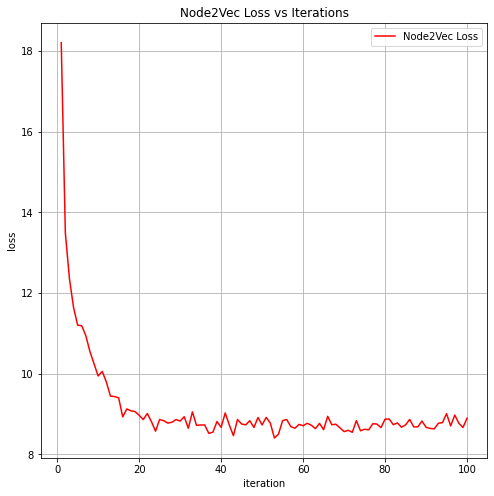

In [ ]:
x = [i for i in range(1,NUM_ITER+1)]
plt.figure(figsize=(8,8))
plt.plot(x, losses1, 'r', label='Node2Vec Loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.title("Node2Vec Loss vs Iterations")
fig.savefig('Node2VecLoss_iter.png')

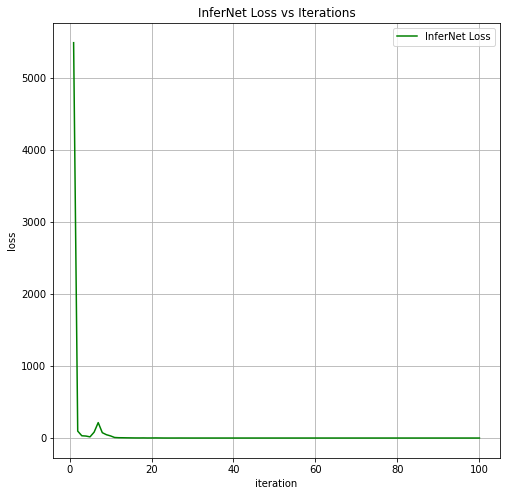

In [ ]:
x = [i for i in range(1,NUM_ITER+1)]
plt.figure(figsize=(8,8))
plt.plot(x, list(losses2), 'g', label='InferNet Loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.title("InferNet Loss vs Iterations")
fig.savefig('InferNetLoss_iter.png')

## Improve policy

In [ ]:
def improvePolicy(policy, Q, state, eps=0.1):
    q = torch.tensor([0.0, 0.0, 0.0, 0.0])
    for a in [0, 1, 2, 3]:
        if a in Q[state].keys():
            q[a] = Q[state][a]

    policy[state] = np.array([0.0, 0.0, 0.0, 0.0])
    idx = 0
    _, indices = torch.sort(q, descending=True)
    policy[state][indices[idx]] = (1.0-eps)

    while ((state+1)%8 == 0 and indices[idx]==0) or (state>=56 and state<=63 and indices[idx]==1) or (state%8 == 0 and indices[idx]==2) or (state>=0 and state<=7 and indices[idx]==3):
        policy[state][indices[idx]] = 0.0
        idx += 1
        policy[state][indices[idx]] = (1.0-eps)

    num_actions = 4.0
    if (state+1)%8 == 0:
        num_actions -= 1.0
    if state>=56 and state<=63:
        num_actions -= 1.0
    if state%8 == 0:
        num_actions -= 1.0
    if state>=0 and state<=7:
        num_actions -= 1.0

    if (state+1)%8 != 0:
        policy[state][0] += (eps/num_actions)
    if not (state>=56 and state<=63):
        policy[state][1] += (eps/num_actions)
    if state%8 != 0:
        policy[state][2] += (eps/num_actions)
    if not (state>=0 and state<=7):
        policy[state][3] += (eps/num_actions)
    
    return policy

In [ ]:
def walk_freq():
    freq = {}
    for i in range(1000):
        for start in range(NUM_NODES):
            states, a, r = sample_episode(8, start)
            for s in states:
                if s not in freq.keys():
                    freq[s] = 0
                freq[s] += 1
    matrix = np.array([[int(freq[to_node_idx(i,j)]) for i in range(8)] for j in range(8)])
    cm = sns.light_palette("green", as_cmap=True)
    x=pd.DataFrame(matrix).iloc[::-1]
    x=x.style.background_gradient(cmap=cm, axis=None)
    display(x)

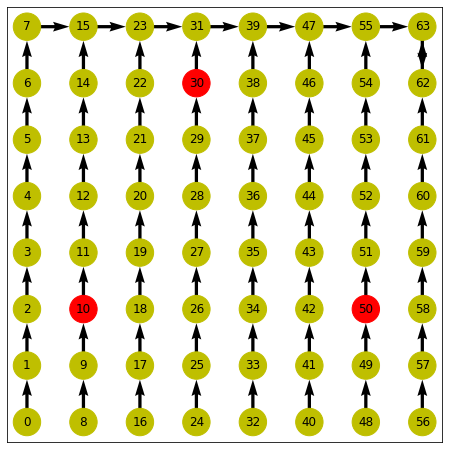

In [ ]:
plot_policy(POLICY)

In [ ]:
model1.eval()
model2.eval()
all_states = model1.forward(torch.tensor([i for i in range(NUM_NODES)])).reshape(NUM_NODES,EMBED_DIM)
imm_rewards = model2.forward(all_states).reshape(NUM_NODES,1)

In [ ]:
cum_reward = []
epsilon = 0.98
model2.eval()
NUM_ITER = 300
WALK_LEN = 5
walk_freq()

for iter in range(1,NUM_ITER+1):
    states, actions, rewards = [], [], []
    for start in range(NUM_NODES):
        s, a, r = sample_episode(WALK_LEN, start)
        states.append(s)
        actions.append(a)
        rewards.append(r)
    
    for i in range(NUM_NODES):
        G = 0.0
        for j in reversed(range(WALK_LEN-1)):
            G += float(imm_rewards[states[i][j+1]])
            s = states[i][j]
            a = actions[i][j]
            vis_prev = False
            for k in range(j):
                if states[i][k]==s and actions[i][k]==a:
                    vis_prev = True
                    break
            if vis_prev:
                continue
            
            RET[s][a].append(G)
            Q[s][a] = np.mean(RET[s][a])
            POLICY = improvePolicy(POLICY, Q, s, epsilon)

    epsilon *= 0.98
    rewards = torch.tensor(rewards).to(DEVICE)
    
    cm = float(torch.sum(rewards))/float(NUM_NODES)
    # if len(cum_reward)>0:
        # cm = (GAMMA*cm) + ((1-GAMMA)*cum_reward[-1])
    cum_reward.append(cm)

    print("iter : "+str(iter)+" |  cum_reward : "+str(cum_reward[-1]))
    if iter in [5, 10, 20, 30, 50, 75, 150, 300]:
        walk_freq()

,0,1,2,3,4,5,6,7
7,5410,7576,7253,7169,7159,7289,7662,5472
6,7575,9472,9040,8629,8795,9039,9321,7523
5,7223,9012,8665,8350,8330,8580,8866,7166
4,7138,8801,8410,8310,8193,8357,8621,7176
3,7011,8814,8415,8326,8225,8467,8904,7191
2,7277,8932,8555,8400,8267,8452,8941,7118
1,7727,9425,8994,8730,8795,8933,9256,7404
0,5697,7923,7381,7248,7353,7368,7532,5357


iter : 1 |  cum_reward : 0.171875
iter : 2 |  cum_reward : 0.28125
iter : 3 |  cum_reward : 0.28125
iter : 4 |  cum_reward : 0.421875
iter : 5 |  cum_reward : 0.359375


,0,1,2,3,4,5,6,7
7,5420,7415,7053,8488,7762,7341,7436,6026
6,6765,8948,9377,11898,9740,8535,8095,6960
5,6546,8382,8674,9971,8328,7171,7657,7006
4,6151,8427,7534,7188,7014,7123,8505,7295
3,6895,10819,8445,7051,7491,8462,10387,8201
2,7799,12130,9528,7274,7366,9772,12602,9739
1,7255,9592,8705,7396,8091,8712,9676,7845
0,4786,7262,6897,6297,7252,6439,6711,4892


iter : 6 |  cum_reward : 0.375
iter : 7 |  cum_reward : 0.328125
iter : 8 |  cum_reward : 0.5
iter : 9 |  cum_reward : 0.296875
iter : 10 |  cum_reward : 0.4375


,0,1,2,3,4,5,6,7
7,3836,6520,8467,13147,8159,6095,7141,6365
6,5083,7752,10062,16509,9722,8134,7859,6130
5,5032,7581,8559,11303,6964,6273,6151,5184
4,5622,8295,6590,6287,5974,8180,7320,6587
3,7964,13947,8629,6080,6061,9447,11569,8804
2,9824,16439,11127,7618,6270,8949,15790,12656
1,7234,9528,9423,7559,7194,6859,9458,7934
0,4077,5593,5452,5332,6088,5245,6514,4453


iter : 11 |  cum_reward : 0.515625
iter : 12 |  cum_reward : 0.59375
iter : 13 |  cum_reward : 0.390625
iter : 14 |  cum_reward : 0.5
iter : 15 |  cum_reward : 0.453125
iter : 16 |  cum_reward : 0.640625
iter : 17 |  cum_reward : 0.65625
iter : 18 |  cum_reward : 0.546875
iter : 19 |  cum_reward : 0.359375
iter : 20 |  cum_reward : 0.515625


,0,1,2,3,4,5,6,7
7,2841,5436,8333,16859,8361,4754,4856,5174
6,3645,6438,10123,25025,13629,8221,7929,6069
5,3514,5886,7931,14447,9346,4942,4379,3880
4,4351,6675,4964,5207,4568,4414,4671,5193
3,8454,11937,6618,4224,4744,8719,9209,7208
2,18957,24154,9402,6177,7457,15353,23697,11533
1,8276,11562,7414,4646,5721,8302,16061,7682
0,3553,4714,4898,3421,3369,3819,5129,3529


iter : 21 |  cum_reward : 0.546875
iter : 22 |  cum_reward : 0.671875
iter : 23 |  cum_reward : 0.6875
iter : 24 |  cum_reward : 0.484375
iter : 25 |  cum_reward : 0.484375
iter : 26 |  cum_reward : 0.734375
iter : 27 |  cum_reward : 0.765625
iter : 28 |  cum_reward : 0.71875
iter : 29 |  cum_reward : 0.625
iter : 30 |  cum_reward : 0.71875


,0,1,2,3,4,5,6,7
7,2275,4596,8181,23041,8338,3770,3139,2257
6,2695,5220,9807,33434,14635,7817,6799,4051
5,2530,4570,7050,15748,9562,5709,3620,2895
4,3126,3843,3613,4122,3607,3569,3688,4317
3,7940,10816,5772,3291,3362,7589,8536,6477
2,25070,30864,8920,4863,4280,15143,30837,12284
1,8193,12358,8116,3632,4617,8484,21789,7450
0,2894,3966,4410,2708,2612,3548,6324,3231


iter : 31 |  cum_reward : 0.90625
iter : 32 |  cum_reward : 0.875
iter : 33 |  cum_reward : 0.796875
iter : 34 |  cum_reward : 0.765625
iter : 35 |  cum_reward : 0.703125
iter : 36 |  cum_reward : 0.875
iter : 37 |  cum_reward : 0.71875
iter : 38 |  cum_reward : 1.0
iter : 39 |  cum_reward : 1.0
iter : 40 |  cum_reward : 1.015625
iter : 41 |  cum_reward : 0.953125
iter : 42 |  cum_reward : 0.890625
iter : 43 |  cum_reward : 1.0
iter : 44 |  cum_reward : 0.875
iter : 45 |  cum_reward : 0.9375
iter : 46 |  cum_reward : 0.90625
iter : 47 |  cum_reward : 0.96875
iter : 48 |  cum_reward : 1.109375
iter : 49 |  cum_reward : 1.0
iter : 50 |  cum_reward : 1.140625


,0,1,2,3,4,5,6,7
7,1599,3467,7523,34124,8613,4244,2167,1616
6,1809,3711,8361,45858,15676,7540,4318,2934
5,1782,3359,5230,13375,5101,2463,2166,1947
4,2161,2495,2235,2722,2200,2373,3806,3669
3,6817,9197,3993,2049,3501,7013,8374,8028
2,34111,39779,6525,2193,3136,15882,44828,37637
1,6933,11070,6386,2264,3383,6669,7270,6813
0,2075,2631,3158,1787,1754,2000,2149,1951


iter : 51 |  cum_reward : 1.171875
iter : 52 |  cum_reward : 0.984375
iter : 53 |  cum_reward : 1.078125
iter : 54 |  cum_reward : 1.015625
iter : 55 |  cum_reward : 1.125
iter : 56 |  cum_reward : 1.015625
iter : 57 |  cum_reward : 1.0
iter : 58 |  cum_reward : 0.828125
iter : 59 |  cum_reward : 1.078125
iter : 60 |  cum_reward : 1.140625
iter : 61 |  cum_reward : 1.046875
iter : 62 |  cum_reward : 1.046875
iter : 63 |  cum_reward : 1.296875
iter : 64 |  cum_reward : 1.203125
iter : 65 |  cum_reward : 1.09375
iter : 66 |  cum_reward : 1.28125
iter : 67 |  cum_reward : 1.3125
iter : 68 |  cum_reward : 1.109375
iter : 69 |  cum_reward : 1.3125
iter : 70 |  cum_reward : 1.1875
iter : 71 |  cum_reward : 1.21875
iter : 72 |  cum_reward : 1.109375
iter : 73 |  cum_reward : 1.25
iter : 74 |  cum_reward : 1.234375
iter : 75 |  cum_reward : 1.15625


,0,1,2,3,4,5,6,7
7,1319,2728,6347,45186,6919,3141,1585,1302
6,1406,2836,6460,56583,14300,6304,3658,2498
5,1315,2580,4112,11365,3619,1694,1538,1447
4,1535,1704,1549,1798,1498,1655,2915,2813
3,5209,7356,2985,1472,2723,5693,6677,6520
2,42131,47392,4901,1503,2129,14228,54391,47621
1,5364,9367,5238,1596,2640,5466,5329,5311
0,1447,1820,2561,1352,1365,1535,1530,1439


iter : 76 |  cum_reward : 1.375
iter : 77 |  cum_reward : 1.125
iter : 78 |  cum_reward : 1.21875
iter : 79 |  cum_reward : 1.25
iter : 80 |  cum_reward : 1.296875
iter : 81 |  cum_reward : 1.25
iter : 82 |  cum_reward : 1.171875
iter : 83 |  cum_reward : 1.34375
iter : 84 |  cum_reward : 1.203125
iter : 85 |  cum_reward : 1.28125
iter : 86 |  cum_reward : 1.359375
iter : 87 |  cum_reward : 1.25
iter : 88 |  cum_reward : 1.359375
iter : 89 |  cum_reward : 1.28125
iter : 90 |  cum_reward : 1.296875
iter : 91 |  cum_reward : 1.296875
iter : 92 |  cum_reward : 1.390625
iter : 93 |  cum_reward : 1.328125
iter : 94 |  cum_reward : 1.21875
iter : 95 |  cum_reward : 1.390625
iter : 96 |  cum_reward : 1.40625
iter : 97 |  cum_reward : 1.296875
iter : 98 |  cum_reward : 1.421875
iter : 99 |  cum_reward : 1.296875
iter : 100 |  cum_reward : 1.34375
iter : 101 |  cum_reward : 1.4375
iter : 102 |  cum_reward : 1.296875
iter : 103 |  cum_reward : 1.421875
iter : 104 |  cum_reward : 1.453125
iter : 

,0,1,2,3,4,5,6,7
7,1048,2111,3889,59817,4960,3132,2088,1045
6,1065,2141,3833,68689,10411,4264,2130,1068
5,1069,2107,3137,7971,2273,1081,1087,1060
4,1062,1129,1111,1132,1073,1095,2148,2107
3,2789,4836,2162,1073,2079,4214,3848,3845
2,51494,55905,2694,1095,1198,10913,65180,59763
1,2771,6795,4192,1109,2095,4251,2823,2872
0,1046,1149,2088,1062,1052,1102,1096,1076


iter : 151 |  cum_reward : 1.515625
iter : 152 |  cum_reward : 1.546875
iter : 153 |  cum_reward : 1.5625
iter : 154 |  cum_reward : 1.5625
iter : 155 |  cum_reward : 1.546875
iter : 156 |  cum_reward : 1.5
iter : 157 |  cum_reward : 1.546875
iter : 158 |  cum_reward : 1.515625
iter : 159 |  cum_reward : 1.546875
iter : 160 |  cum_reward : 1.5
iter : 161 |  cum_reward : 1.515625
iter : 162 |  cum_reward : 1.5625
iter : 163 |  cum_reward : 1.5
iter : 164 |  cum_reward : 1.546875
iter : 165 |  cum_reward : 1.5625
iter : 166 |  cum_reward : 1.578125
iter : 167 |  cum_reward : 1.546875
iter : 168 |  cum_reward : 1.5625
iter : 169 |  cum_reward : 1.53125
iter : 170 |  cum_reward : 1.53125
iter : 171 |  cum_reward : 1.5625
iter : 172 |  cum_reward : 1.578125
iter : 173 |  cum_reward : 1.5
iter : 174 |  cum_reward : 1.5625
iter : 175 |  cum_reward : 1.546875
iter : 176 |  cum_reward : 1.578125
iter : 177 |  cum_reward : 1.5625
iter : 178 |  cum_reward : 1.578125
iter : 179 |  cum_reward : 1.5

,0,1,2,3,4,5,6,7
7,1005,2004,3043,63810,4047,3003,2003,1001
6,1002,2000,3039,71869,9078,4013,2006,1001
5,1007,2010,3012,7052,2010,1004,1002,1000
4,1001,1007,1004,1006,1008,1005,2006,2004
3,2032,4036,2007,1002,2005,4008,3045,3044
2,53869,57907,2036,1007,1013,10040,67834,62804
1,2025,6047,4013,1006,2003,4010,2054,2050
0,1001,1008,2011,1010,1000,1004,1005,1002


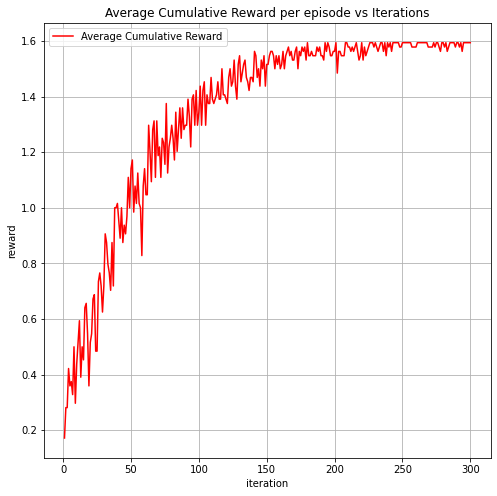

In [ ]:
x = [i for i in range(1,len(cum_reward)+1)]
plt.figure(figsize=(8,8))
plt.plot(x, cum_reward, 'r', label='Average Cumulative Reward')
plt.xlabel('iteration')
plt.ylabel('reward')
plt.grid()
plt.legend()
plt.title("Average Cumulative Reward per episode vs Iterations")
fig.savefig('CumReward_iter.png')

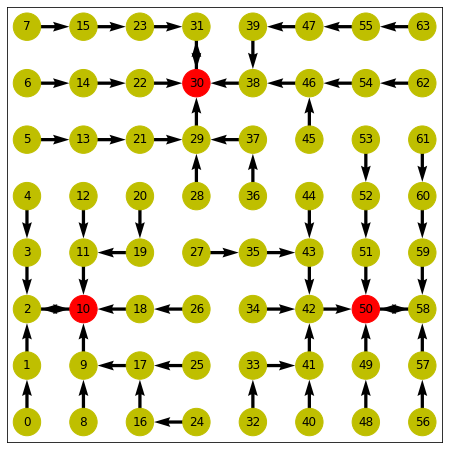

In [ ]:
plot_policy(POLICY)